# Bibliotecas

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [3]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Carregando os dados iniciais

In [4]:
df = pd.read_csv("solicitacoescredito.csv");
df.head()

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.0,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.0,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,...,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.0,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.0,89000.0,2020-02-04T15:06:28


In [7]:
df_temporal = df[['dataAprovadoNivelAnalista', 'dataAprovadoEmComite', 'valorAprovado']]
df_temporal['dataAprovadoEmComite'].fillna(df_temporal['dataAprovadoNivelAnalista'], inplace=True)
df_temporal.drop('dataAprovadoNivelAnalista', axis=1, inplace=True)
df_temporal.rename({'dataAprovadoEmComite': 'data'}, axis=1, inplace=True)
df_temporal.dropna(inplace=True)
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7569 entries, 0 to 8961
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   data           7569 non-null   object 
 1   valorAprovado  7569 non-null   float64
dtypes: float64(1), object(1)
memory usage: 177.4+ KB


In [8]:
df_temporal.data[0][:-9]
df_temporal.data = [x[:-9] for x in df_temporal.data]
df_temporal.valorAprovado = df_temporal.valorAprovado.astype('int64')
df_temporal

,data,valorAprovado
0,2020-02-03,50000
2,2020-02-04,20000
3,2020-02-04,15000
4,2020-02-04,50000
5,2020-02-04,20000
...,...,...
8956,2021-02-25,45000
8957,2021-02-25,15000
8958,2021-02-25,1500000
8960,2021-02-25,20000


In [9]:
df_temporal_agrupado = df_temporal.groupby('data', as_index=False).sum()
df_temporal_agrupado.sort_values('data', inplace=True)
df_temporal_agrupado

,data,valorAprovado
0,2020-02-03,50000
1,2020-02-04,1243000
2,2020-02-05,2952000
3,2020-02-06,5545000
4,2020-02-07,4685000
...,...,...
259,2021-02-19,7911900
260,2021-02-22,4272000
261,2021-02-23,13826500
262,2021-02-24,7255000


In [10]:
df_base_dias = pd.date_range(start='2020-02-03', end='2021-02-25')
df_base_dias = df_base_dias.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
df_base_dias = pd.DataFrame(df_base_dias, columns=['data'])
df_base_dias

,data
0,2020-02-03
1,2020-02-04
2,2020-02-05
3,2020-02-06
4,2020-02-07
...,...
384,2021-02-21
385,2021-02-22
386,2021-02-23
387,2021-02-24


In [27]:
df_temporal = pd.merge(df_base_dias, df_temporal_agrupado, how='left')
df_temporal

,data,valorAprovado
0,2020-02-03,50000.0
1,2020-02-04,1243000.0
2,2020-02-05,2952000.0
3,2020-02-06,5545000.0
4,2020-02-07,4685000.0
...,...,...
384,2021-02-21,NaN
385,2021-02-22,4272000.0
386,2021-02-23,13826500.0
387,2021-02-24,7255000.0


In [28]:
df_temporal.isnull().sum()

data               0
valorAprovado    125
dtype: int64

In [29]:
df_temporal.valorAprovado[df.valorAprovado == 0].count()

0

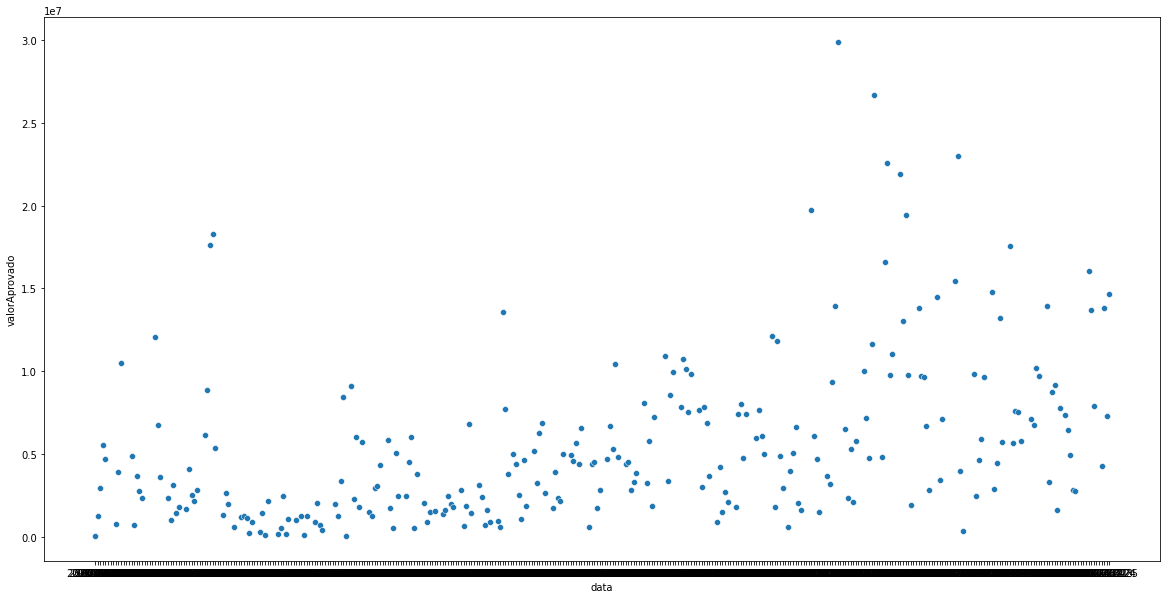

In [23]:
ig = plt.figure(figsize=(20,10))
sns.scatterplot(x=df_temporal.data, y=df_temporal.valorAprovado)
plt.show()

In [24]:
imputer = KNNImputer(n_neighbors=1, weights='distance')
df_temporal['valorAprovado'] = imputer.fit_transform(df_temporal[['valorAprovado']])
df_temporal.valorAprovado = df_temporal.valorAprovado.astype('int64')
df_temporal

,data,valorAprovado
0,2020-02-03,50000
1,2020-02-04,1243000
2,2020-02-05,2952000
3,2020-02-06,5545000
4,2020-02-07,4685000
...,...,...
384,2021-02-21,5441439
385,2021-02-22,4272000
386,2021-02-23,13826500
387,2021-02-24,7255000


In [31]:
df_temporal.valorAprovado.fillna(0, inplace=True)

In [32]:
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 388
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   data           389 non-null    object 
 1   valorAprovado  389 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


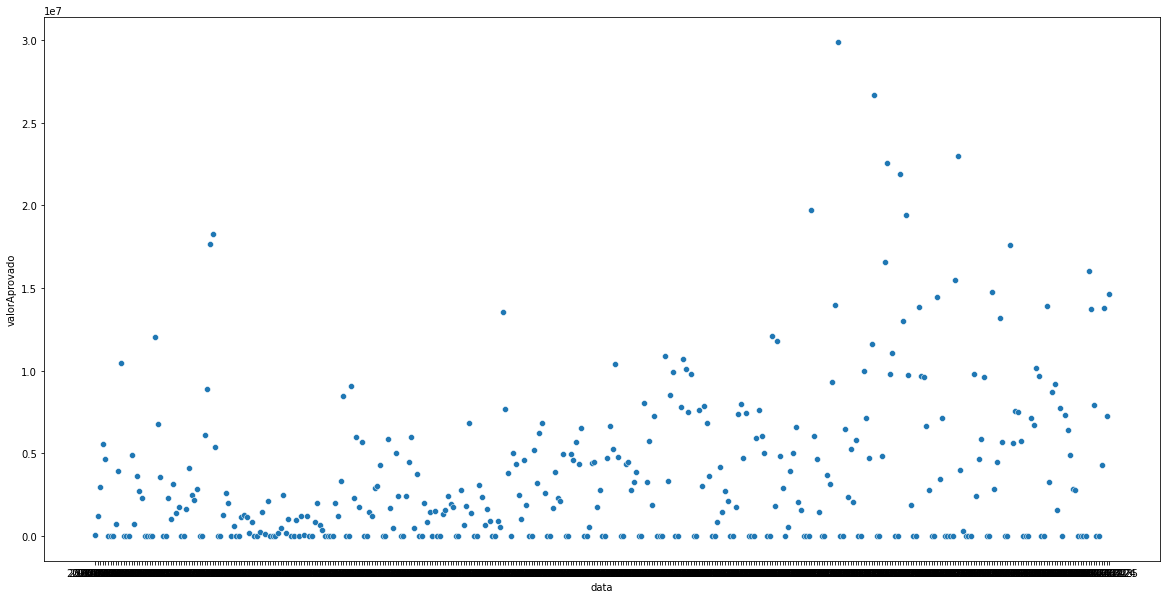

In [33]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=df_temporal.data, y=df_temporal.valorAprovado)
plt.show()

In [37]:
X = np.array(df_temporal.valorAprovado)
X = X.astype('float32').reshape(-1,1)

In [38]:
#Normaliza o dataset
scaler = MinMaxScaler()

#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [41]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

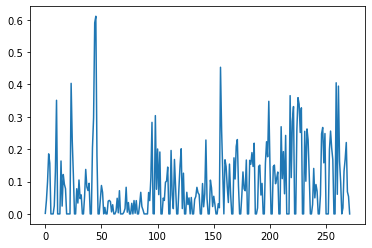

In [42]:
plt.plot(train)

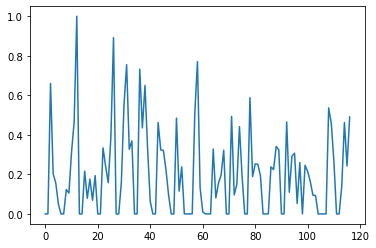

In [43]:
plt.plot(test)

In [64]:
# quantidade de atrasos
look_back = 7

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [65]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [66]:
X_train.shape

(264, 7, 1)

In [67]:
# Cria e treina a rede LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
264/264 [==============================] - 2s 2ms/step - loss: 0.0882 - mse: 0.0160
Epoch 2/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0742 - mse: 0.0115
Epoch 3/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0706 - mse: 0.0099
Epoch 4/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0751 - mse: 0.0126
Epoch 5/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0706 - mse: 0.0127
Epoch 6/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0590 - mse: 0.0080
Epoch 7/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0672 - mse: 0.0109
Epoch 8/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0593 - mse: 0.0085
Epoch 9/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0662 - mse: 0.0103
Epoch 10/100
264/264 [==============================] - 1s 2ms/step - loss: 0.0601 - mse: 0.0087
Epoch 11/100
264/264 [=================

In [68]:
model.evaluate(X_train, y_train)

9/9 [==============================] - 1s 2ms/step - loss: 0.0406 - mse: 0.0054


[0.04060003533959389, 0.005440169014036655]

In [58]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [59]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [60]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2409940.75 RMSE
Test Score: 6301848.35 RMSE


In [61]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [62]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

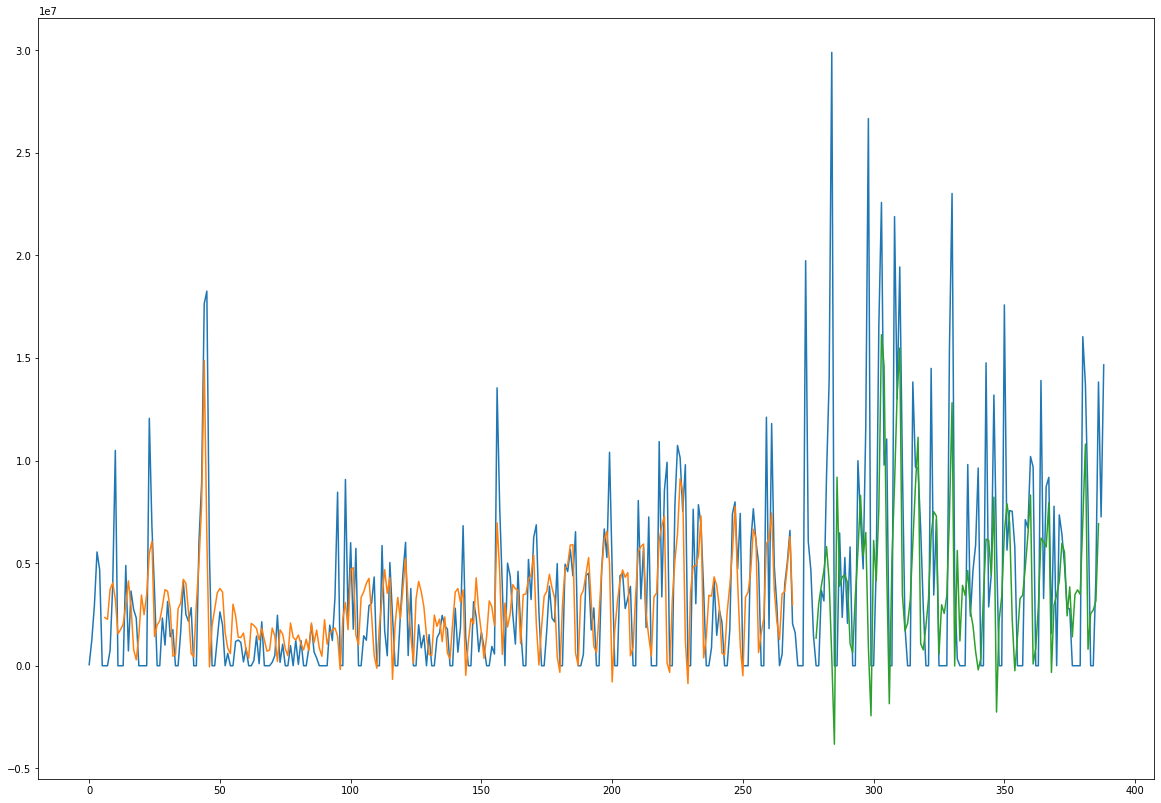

In [63]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()